In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython
import librosa
import soundfile
import math

In [16]:
IPython.display.Audio("input.wav")

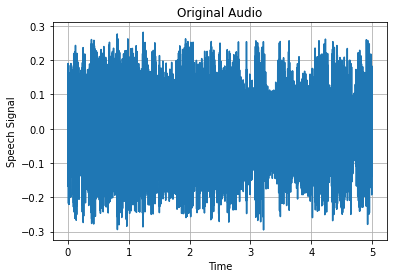

In [17]:
file_path = './input.wav'
signal,sr = librosa.load(file_path)
t = np.arange(len(signal))/sr
plt.figure(figsize=(6,4))
plt.plot(t,signal)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Original Audio')
plt.grid()
plt.show()

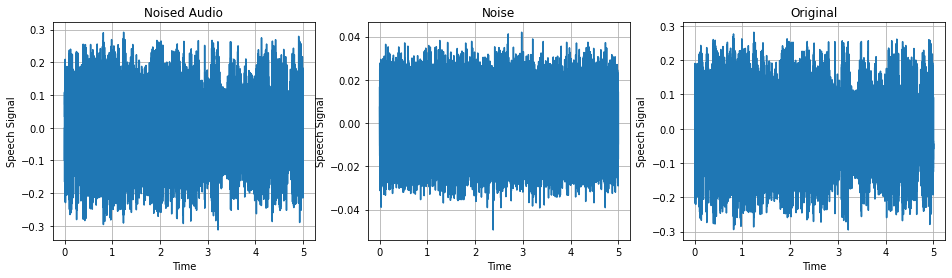

In [18]:
RMS=math.sqrt(np.mean(signal**2))

STD_n= 0.01
noise=np.random.normal(0, STD_n, signal.shape[0])
#
# # X=np.fft.rfft(noise)
# # radius,angle=to_polar(X)
#
signal_noise = signal+noise
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(t,signal_noise)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Noised Audio')
plt.grid()
plt.subplot(1,3,2)
plt.plot(t,noise)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Noise')
plt.grid()
plt.subplot(1,3,3)
plt.plot(t,signal)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Original')
plt.grid()
plt.show()

In [19]:
soundfile.write('noised_input.wav',signal_noise,sr)
IPython.display.Audio("noised_input.wav")

In [21]:
def chopper(input_signal, window_length,hopping_size):
    hopping_samples = window_length*hopping_size
    number_of_segments = int(np.fix(((len(input_signal)-window_length)/hopping_samples)+1))
    chopped_signal = []
    for i in range(number_of_segments):
        if (i+1)*window_length >= len(input_signal):
            filter_coeff = np.zeros(window_length)
            filter_coeff[:((i+1)*window_length)-len(input_signal)] = input_signal[(i*window_length):]
        else:
            filter_coeff = input_signal[i*window_length:(i+1)*window_length]
        chopped_signal.append(filter_coeff)
    return chopped_signal
# Setting up the variables before jumping into processing.
WinLenSec = 0.0025
HopPercent = 1
AROrder = 10
NumIter = 5
WinLenSamples = int(np.fix(WinLenSec*sr))
chopped_signal = chopper(signal_noise,WinLenSamples,HopPercent)
# chopped_signal = [signal]
H = np.zeros((1,AROrder))
H[0,-1] = 1
R = np.var(noise)
coeffs = librosa.lpc(np.array(chopped_signal),order=AROrder)
# print(coeffs.shape)
Q = np.var(coeffs,1).reshape((-1,1))
P = R*np.eye(AROrder)
output = np.zeros(signal.shape).reshape((-1,1))
output[:AROrder] = signal_noise[:AROrder].reshape((-1,1))
output_p = signal_noise[:AROrder].reshape((-1,1))

In [14]:
i = AROrder+1
j = AROrder+1
for k in range(len(chopped_signal)):
    jStart = j
    output_old = output_p
    #print("output_p.shape : ",output_p.shape)
    for l in range(NumIter):
        A = np.vstack((np.hstack((np.zeros((AROrder-1,1)),np.eye(AROrder-1))),np.flip(-1*coeffs[k][1:])))
        for ii in range(i,WinLenSamples,1):
            # print("i: ,",i)
            output_c = A@output_p
            Pc = (A@P@A.T) + (H.T*Q[k]@H)
            K = (Pc@H.T)@np.linalg.inv((H@Pc@H.T)+R)
            output_p = output_c + K*(chopped_signal[k][ii]-(H@output_c))
            output[j-AROrder:j] = output_p
            P = (np.eye(AROrder)-K@H)@Pc
            j += 1
        i = 0
        if l< NumIter:
            j = jStart
            output_p = output_old
        coeffs[k,:] = librosa.lpc(output[(k)*WinLenSamples:(k+1)*WinLenSamples].T,order=AROrder)
        Q[k] = np.var(coeffs[k,:])

print(output.shape)


(110250, 1)


In [8]:
soundfile.write('extracted_input.wav',output,sr)
IPython.display.Audio("extracted_input.wav")

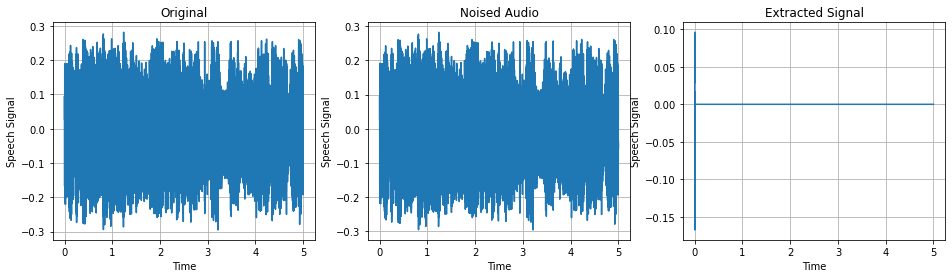

In [9]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(t,signal)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Original')
plt.grid()
plt.subplot(1,3,2)
plt.plot(t,signal_noise)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Noised Audio')
plt.grid()

plt.subplot(1,3,3)
plt.plot(t,output)
plt.xlabel('Time')
plt.ylabel('Speech Signal')
plt.title('Extracted Signal')
plt.grid()
plt.show()